In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import pearsonr, spearmanr, chi2_contingency, mannwhitneyu, ttest_ind, ttest_1samp, probplot
from tqdm import trange, tqdm
import os
import pickle

# for run l analysis
from pathlib import Path

## Setup

# random seed
RNG = np.random.default_rng(123)

# styling
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 12
})

# config
CFG = dict(
    n_trials_tab = 300,
    n_trials_dawh = 300,
    n_datasets   = 24,
    rw_restarts  = 6,
    sp_restarts  = 10,
)

print("Configuration:", CFG)
os.makedirs("figs", exist_ok=True)

# data indices given in dataset descriptiokn
DATASET_TO_TASK = {
    0: "DAWH",
    1: "TAB",
    2: "TAB",
    3: "DAWH",
    4: "DAWH",
    5: "TAB"
}

# load shin data
def load_shin_data(pkl_path="shin_data.pkl"):

    try:
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)

        for idx in range(len(data)):
            task = DATASET_TO_TASK.get(idx, "UNKNOWN")
            n_sessions = len(data[idx]) if hasattr(data[idx], '__len__') else 0
            print(f"  Dataset {idx}: {task} task, {n_sessions} sessions")
        return data


    except FileNotFoundError:
        print(f"file not found")
        return None

    except Exception as e:
        print(f"Error")
        return None

# extract session data
def extract_session_data(data, dataset_idx, session_idx):

    if data is None:
        return None, None, None

    task_type = DATASET_TO_TASK.get(dataset_idx, None)

    if task_type is None:
        return None, None, None

    try:

        session_data = data[dataset_idx][session_idx]
        choices = session_data[0]
        rewards = session_data[1]
        return choices, rewards, task_type

    except (IndexError, KeyError, TypeError) as e:
        print("Error")
        return None, None, None

# Helper functions
def aic(ll, k, n):
    return 2 * k - 2 * ll

def bic(ll, k, n):
    return k * np.log(max(n, 1)) - 2 * ll

def softmax_prob(a_left, a_right, beta):
    r_diff = a_left - a_right
    x = np.clip(-beta * r_diff, -50, 50)
    return 1.0 / (1.0 + np.exp(-x))

#Stacking param for sp
def compute_stack_parameter(a_est, run_length):

    if a_est <= 1e-10:
        return run_length + 1.0
    one_minus_a = 1.0 - a_est
    if abs(one_minus_a - 1.0) < 1e-10:
        return run_length + 1.0
    return (1.0 - one_minus_a ** (run_length + 1)) / a_est

# env funcs
def simulate_env_TAB_prob(t, block_len=40, high=0.8, low=0.2):
    b = (t // block_len) % 2
    return (high, low) if b == 0 else (low, high)

def daw_prob(base, inc, since, max_p):

    return min(max_p, base + inc * since)

# RW model simulation
def simulate_RW(alpha, beta, n_trials=200, task="TAB", **task_kwargs):

    A_L, A_R = 0.5, 0.5
    choices = np.zeros(n_trials, dtype=int)
    rewards = np.zeros(n_trials, dtype=int)

    base = task_kwargs.get("base", 0.05)
    inc = task_kwargs.get("inc", 0.08)
    max_p = task_kwargs.get("max_p", 0.95)
    block_len = task_kwargs.get("block_len", 40)
    high, low = 0.8, 0.2
    since_L, since_R = 0, 0

    for t in range(n_trials):
        p_right = softmax_prob(A_L, A_R, beta)
        a = RNG.binomial(1, p_right)
        choices[t] = a

        if task == "TAB":
            pL, pR = simulate_env_TAB_prob(t, block_len, high, low)
        elif task == "DAWH":
            pL = daw_prob(base, inc, since_L, max_p)
            pR = daw_prob(base, inc, since_R, max_p)
        else:
            raise ValueError("Value error")



        p = pR if a == 1 else pL
        r = RNG.binomial(1, p)
        rewards[t] = r

        if a == 0:
            A_L = (1.0 - alpha) * A_L + alpha * r
            since_L = 0
            since_R += 1

        else:
            A_R = (1.0 - alpha) * A_R + alpha * r
            since_R = 0
            since_L += 1

    return choices, rewards


# log likelihood for rw model
def loglik_RW(alpha, beta, choices, rewards):

    A_L, A_R = 0.5, 0.5
    ll = 0.0

    for a, r in zip(choices, rewards):
        p_right = softmax_prob(A_L, A_R, beta)
        p = p_right if a == 1 else (1.0 - p_right)
        p = np.clip(p, 1e-12, 1.0 - 1e-12)
        ll += np.log(p)

        if a == 0:
            A_L = (1.0 - alpha) * A_L + alpha * r
        else:
            A_R = (1.0 - alpha) * A_R + alpha * r
    return ll

# SP model
def simulate_SP(alpha, beta, n_trials=200, task="DAWH", **task_kwargs):

    A_L, A_R = 0.5, 0.5
    choices = np.zeros(n_trials, dtype=int)
    rewards = np.zeros(n_trials, dtype=int)

    base = task_kwargs.get("base", 0.05)
    inc = task_kwargs.get("inc", 0.08)
    max_p = task_kwargs.get("max_p", 0.95)
    block_len = task_kwargs.get("block_len", 40)
    high, low = 0.8, 0.2
    run_length_L = 0
    run_length_R = 0

    for t in range(n_trials):

        X_L = compute_stack_parameter(A_L, run_length_R)
        X_R = compute_stack_parameter(A_R, run_length_L)

        S_L = A_L * X_L
        S_R = A_R * X_R

        p_right = softmax_prob(S_L, S_R, beta)
        a = RNG.binomial(1, p_right)
        choices[t] = a

        if task == "TAB":
            pL, pR = simulate_env_TAB_prob(t, block_len, high, low)

        elif task == "DAWH":
            since_L = run_length_R
            since_R = run_length_L
            pL = daw_prob(base, inc, since_L, max_p)
            pR = daw_prob(base, inc, since_R, max_p)

        else:
            raise ValueError("Value Error")

        p = pR if a == 1 else pL
        r = RNG.binomial(1, p)
        rewards[t] = r

        if a == 0:
            A_L = (1.0 - alpha) * A_L + alpha * r
            run_length_L += 1
            run_length_R = 0

        else:
            A_R = (1.0 - alpha) * A_R + alpha * r
            run_length_R += 1
            run_length_L = 0

    return choices, rewards

# log likelihood SP model
def loglik_SP(alpha, beta, choices, rewards):

    A_L, A_R = 0.5, 0.5
    run_length_L = 0
    run_length_R = 0
    ll = 0.0

    for a, r in zip(choices, rewards):

        X_L = compute_stack_parameter(A_L, run_length_R)
        X_R = compute_stack_parameter(A_R, run_length_L)

        S_L = A_L * X_L

        S_R = A_R * X_R


        p_right = softmax_prob(S_L, S_R, beta)
        p = p_right if a == 1 else (1.0 - p_right)
        p = np.clip(p, 1e-12, 1.0 - 1e-12)
        ll += np.log(p)

        if a == 0:
            A_L = (1.0 - alpha) * A_L + alpha * r
            run_length_L += 1
            run_length_R = 0

        else:
            A_R = (1.0 - alpha) * A_R + alpha * r
            run_length_R += 1
            run_length_L = 0

    return ll

# RW Fit function
def fit_RW(choices, rewards, n_restarts=None, show_progress=False):
    if n_restarts is None:
        n_restarts = CFG["rw_restarts"]

    best = None
    n = len(choices)
    bounds = [(1e-4, 1.0), (0.5, 50.0)]

    def nll(theta):
        a, b = theta
        return -loglik_RW(a, b, choices, rewards)

    restart_range = tqdm(range(n_restarts), desc="Fitting RW", leave=False, disable=not show_progress)

    for _ in restart_range:
        x0 = np.array([RNG.uniform(0.05, 0.6),
                       RNG.uniform(1.0, 10.0)])
        res = minimize(nll, x0, bounds=bounds, method="L-BFGS-B")
        if (best is None) or (res.fun < best["fun"]):
            best = {"x": res.x, "fun": res.fun}

    alpha, beta = best["x"]
    ll = -best["fun"]
    k = 2
    return dict(

        model="RW",
        alpha=float(alpha), beta=float(beta),
        ll=float(ll), k=k,
        AIC=float(aic(ll, k, n)),
        BIC=float(bic(ll, k, n))

    )

#Fit SP function
def fit_SP(choices, rewards, n_restarts=None, show_progress=False):

    if n_restarts is None:
        n_restarts = CFG["sp_restarts"]

    best = None
    n = len(choices)
    # alpha and beta bounds
    bounds = [(1e-4, 1.0 - 1e-4), (0.5, 15.0)]

    def nll(theta):
        a, b = theta
        return -loglik_SP(a, b, choices, rewards)

    restart_range = tqdm(range(n_restarts), desc="Fitting SP", leave=False, disable=not show_progress)

    for _ in restart_range:

        x0 = np.array([RNG.uniform(0.05, 0.6),
                       RNG.uniform(1.0, 10.0)])

        res = minimize(nll, x0, bounds=bounds, method="L-BFGS-B",
                       options={"maxiter": 600, "ftol": 1e-9})

        if (best is None) or (res.fun < best["fun"]):
            best = {"x": res.x, "fun": res.fun}


    alpha, beta = best["x"]
    ll = -best["fun"]
    k = 2

    return dict(
        model="SP",
        alpha=float(alpha), beta=float(beta),
        ll=float(ll), k=k,
        AIC=float(aic(ll, k, n)),
        BIC=float(bic(ll, k, n))
    )




Configuration: {'n_trials_tab': 300, 'n_trials_dawh': 300, 'n_datasets': 24, 'rw_restarts': 6, 'sp_restarts': 10}



Parameter Recovery Analysis


Recovering RW parameters - TAB task


ParamRecovery RW: 100%|██████████| 36/36 [00:38<00:00,  1.06s/it]


Recovering SP parameters - DAWH task


ParamRecovery SP: 100%|██████████| 36/36 [01:02<00:00,  1.72s/it]


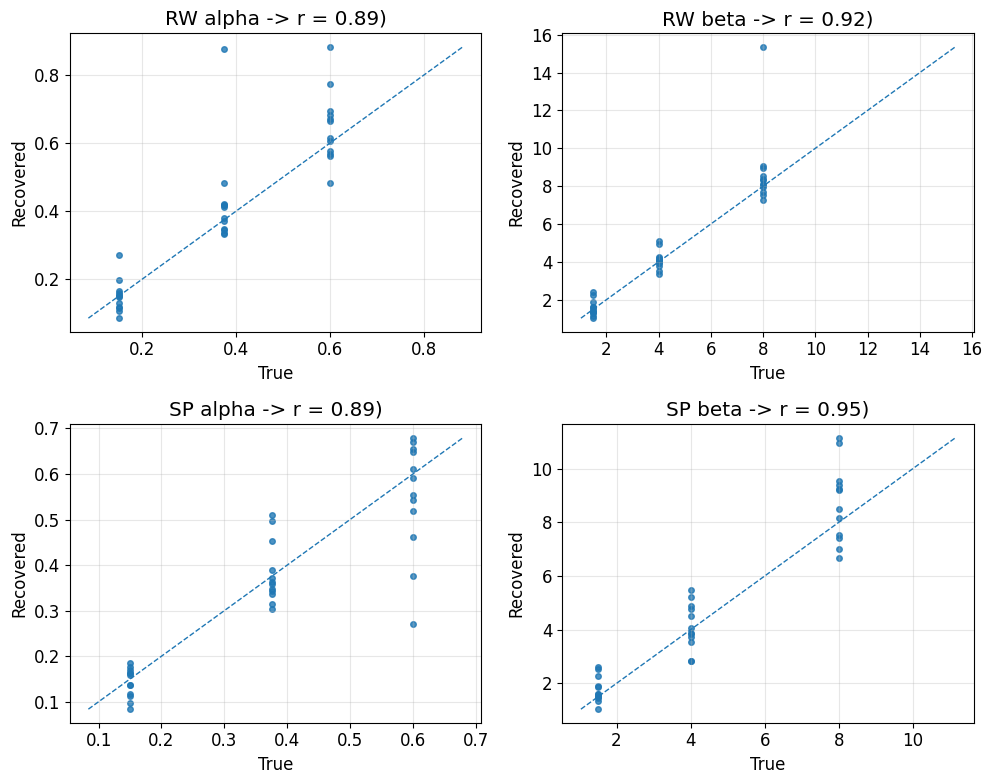


Saved: figs/parameter_recovery.png

Parameter recovery correlations - pearson r:

RW alpha: 0.888 | RW beta: 0.923
SP alpha: 0.894 | SP beta: 0.947


In [ ]:

# parameter recovery

def param_recovery_single(model_name, true_params_list, n_subj=4, n_trials=260,
                          task=None, task_kwargs=None):

    if task_kwargs is None:
        task_kwargs = {}


    T, R = [], []
    pbar = trange(len(true_params_list) * n_subj, desc=f"ParamRecovery {model_name}")

    for params in true_params_list:

        for _ in range(n_subj):

            if model_name == "RW":
                a, b = params
                ch, rw = simulate_RW(a, b, n_trials=n_trials, task=task, **task_kwargs)
                fit = fit_RW(ch, rw)
                T.append([a, b])
                R.append([fit["alpha"], fit["beta"]])

            elif model_name == "SP":
                a, b = params
                ch, rw = simulate_SP(a, b, n_trials=n_trials, task=task, **task_kwargs)
                fit = fit_SP(ch, rw)
                T.append([a, b])
                R.append([fit["alpha"], fit["beta"]])

            else:
                raise ValueError("Value Error")
            pbar.update(1)

    pbar.close()
    return np.array(T), np.array(R)


# param recocery analysis
def compact_param_recovery_summary():

    print("\nParameter Recovery Analysis\n")


    # Parameter grids to test
    RW_TRUE = [(a, b)
               for a in np.linspace(0.15, 0.60, 3)
               for b in (1.5, 4.0, 8.0)]


    SP_TRUE = [(a, b)
               for a in np.linspace(0.15, 0.60, 3)
               for b in (1.5, 4.0, 8.0)]

    print("\nRecovering RW parameters - TAB task")
    T_rw, R_rw = param_recovery_single(
        "RW", RW_TRUE, n_trials=300, task="TAB", task_kwargs={"block_len": 40}
    )


    print("Recovering SP parameters - DAWH task")
    T_sp, R_sp = param_recovery_single(
        "SP", SP_TRUE, n_trials=300, task="DAWH",
        task_kwargs={"base": 0.02, "inc": 0.12, "max_p": 0.98}
    )

    def rstr(true, fit):
        r, _ = pearsonr(true, fit)
        return r

    r_rw_a = rstr(T_rw[:, 0], R_rw[:, 0])
    r_rw_b = rstr(T_rw[:, 1], R_rw[:, 1])


    r_sp_a = rstr(T_sp[:, 0], R_sp[:, 0])
    r_sp_b = rstr(T_sp[:, 1], R_sp[:, 1])

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    def panel(ax, x, y, title):

        lo = float(min(x.min(), y.min()))
        hi = float(max(x.max(), y.max()))

        ax.scatter(x, y, s=16, alpha=0.8)
        ax.plot([lo, hi], [lo, hi], '--', linewidth=1)

        ax.set_xlabel("True")
        ax.set_ylabel("Recovered")
        ax.set_title(title)

    panel(axes[0], T_rw[:, 0], R_rw[:, 0], f"RW alpha -> r = {r_rw_a:.2f})")
    panel(axes[1], T_rw[:, 1], R_rw[:, 1], f"RW beta -> r = {r_rw_b:.2f})")

    panel(axes[2], T_sp[:, 0], R_sp[:, 0], f"SP alpha -> r = {r_sp_a:.2f})")
    panel(axes[3], T_sp[:, 1], R_sp[:, 1], f"SP beta -> r = {r_sp_b:.2f})")

    fig.tight_layout()
    fname = "figs/parameter_recovery.png"
    fig.savefig(fname, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"\nSaved: {fname}")
    print(f"\nParameter recovery correlations - pearson r:\n")
    print(f"RW alpha: {r_rw_a:.3f} | RW beta: {r_rw_b:.3f}")
    print(f"SP alpha: {r_sp_a:.3f} | SP beta: {r_sp_b:.3f}")



compact_param_recovery_summary()




Model Recovery Analysis


TAB Task:



ModelRec[TAB]: 100%|██████████| 24/24 [01:14<00:00,  3.11s/it]



TAB AIC confusion matrix:
 [[12  0]
 [ 0 12]]

TAB BIC confusion matrix:
 [[12  0]
 [ 0 12]]


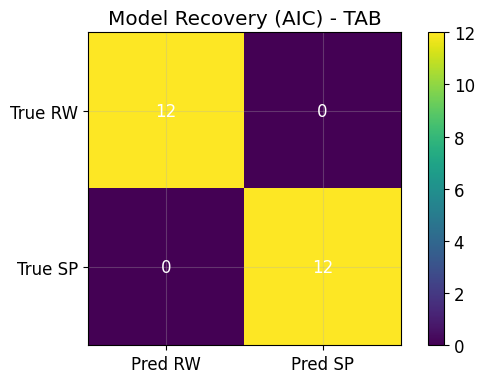

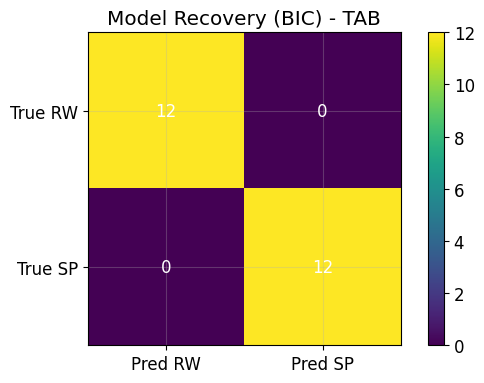


TAB Task Recovery Accuracy:

AIC: 100.0%
BIC: 100.0%

DAWH Task:



ModelRec[DAWH]:  88%|████████▊ | 21/24 [01:01<00:10,  3.35s/it]

In [ ]:
## Model Recovery

# confusion matrix
def confusion(true_labels, pred_labels, labels=("RW", "SP")):

    M = np.zeros((2, 2), dtype=int)
    idx = {lab: i for i, lab in enumerate(labels)}


    for t, p in zip(true_labels, pred_labels):
        M[idx[t], idx[p]] += 1
    return M

# plot cm
def plot_cm(cm, title):

    plt.figure()
    plt.imshow(cm, vmin=0, vmax=cm.max(), cmap="viridis")

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color="white")

    plt.xticks([0, 1], ["Pred RW", "Pred SP"])
    plt.yticks([0, 1], ["True RW", "True SP"])
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    fname = "figs/" + title.replace(" ", "_").replace("—", "-") + ".png"
    plt.savefig(fname, dpi=220, bbox_inches="tight")
    plt.show()


# model recovery test for a given task
def model_recovery_same_task(task, n_datasets=None, n_trials=None):

    assert task in ("TAB", "DAWH")

    if n_datasets is None:
        n_datasets = CFG["n_datasets"]

    if n_trials is None:
        n_trials = CFG["n_trials_tab"] if task == "TAB" else CFG["n_trials_dawh"]

    if task == "TAB":
        env = {"block_len": 40}
    else:
        env = {"base": 0.02, "inc": 0.12, "max_p": 0.98}

    true_labels, pred_AIC, pred_BIC = [], [], []
    pbar = trange(n_datasets, desc=f"ModelRec[{task}]")

    for i in range(n_datasets):
        gen_is_rw = (i < n_datasets // 2)

        if gen_is_rw:
            if task == "TAB":
                a = RNG.uniform(0.20, 0.55)
                b = RNG.uniform(3.0, 8.0)

            else:
                a = RNG.uniform(0.15, 0.50)
                b = RNG.uniform(2.0, 7.0)

            ch, rw = simulate_RW(a, b, n_trials=n_trials, task=task, **env)
            true_labels.append("RW")

        else:
            if task == "TAB":
                a = RNG.uniform(0.15, 0.45)
                b = RNG.uniform(2.0, 7.0)

            else:
                a = RNG.uniform(0.15, 0.50)
                b = RNG.uniform(2.0, 7.0)

            ch, rw = simulate_SP(a, b, n_trials=n_trials, task=task, **env)
            true_labels.append("SP")

        frw = fit_RW(ch, rw)
        fsp = fit_SP(ch, rw)

        pred_AIC.append("RW" if frw["AIC"] < fsp["AIC"] else "SP")
        pred_BIC.append("RW" if frw["BIC"] < fsp["BIC"] else "SP")

        pbar.update(1)

    pbar.close()
    return np.array(true_labels), np.array(pred_AIC), np.array(pred_BIC)

# run analysis
print("\nModel Recovery Analysis\n")


print("\nTAB Task:\n")
true_tab, aic_tab, bic_tab = model_recovery_same_task("TAB")
cm_tab_aic = confusion(true_tab, aic_tab)
cm_tab_bic = confusion(true_tab, bic_tab)
print("\nTAB AIC confusion matrix:\n", cm_tab_aic)
print("\nTAB BIC confusion matrix:\n", cm_tab_bic)
plot_cm(cm_tab_aic, "Model Recovery (AIC) - TAB")
plot_cm(cm_tab_bic, "Model Recovery (BIC) - TAB")

tab_aic_acc = np.trace(cm_tab_aic) / np.sum(cm_tab_aic)
tab_bic_acc = np.trace(cm_tab_bic) / np.sum(cm_tab_bic)
print(f"\nTAB Task Recovery Accuracy:\n")
print(f"AIC: {tab_aic_acc*100:.1f}%")
print(f"BIC: {tab_bic_acc*100:.1f}%")

print("\nDAWH Task:\n")
true_dawh, aic_dawh, bic_dawh = model_recovery_same_task("DAWH")
cm_dawh_aic = confusion(true_dawh, aic_dawh)
cm_dawh_bic = confusion(true_dawh, bic_dawh)

print("\nDAWH AIC confusion matrix:\n", cm_dawh_aic)
print("\nDAWH BIC confusion matrix:\n", cm_dawh_bic)
plot_cm(cm_dawh_aic, "Model Recovery (AIC) - DAWH")
plot_cm(cm_dawh_bic, "Model Recovery (BIC) - DAWH")

dawh_aic_acc = np.trace(cm_dawh_aic) / np.sum(cm_dawh_aic)
dawh_bic_acc = np.trace(cm_dawh_bic) / np.sum(cm_dawh_bic)
print(f"\nDAWH Task Recovery Accuracy:")
print(f"AIC: {dawh_aic_acc*100:.1f}%")
print(f"BIC: {dawh_bic_acc*100:.1f}%")




  Dataset 0: DAWH task, 49 sessions
  Dataset 1: TAB task, 32 sessions
  Dataset 2: TAB task, 122 sessions
  Dataset 3: DAWH task, 38 sessions
  Dataset 4: DAWH task, 81 sessions
  Dataset 5: TAB task, 61 sessions

Fitting models..


Dataset 0 (DAWH): 100%|██████████| 49/49 [00:03<00:00, 13.81session/s, fitted=49]
                                                                                 
Dataset 1 (TAB):  97%|█████████▋| 31/32 [00:02<00:00, 11.88session/s, fitted=81]
                                                                                
Dataset 2 (TAB): 100%|██████████| 122/122 [00:09<00:00, 10.41session/s, fitted=203]
                                                                                   
Dataset 3 (DAWH): 100%|██████████| 38/38 [00:03<00:00, 10.94session/s, fitted=241]
                                                                                  
Dataset 4 (DAWH):  99%|█████████▉| 80/81 [00:06<00:00, 10.54session/s, fitted=322]
                                                                                  
Processing sessions: 100%|██████████| 383/383 [00:31<00:00, 12.31session/s]



Parameter values by task:

TAB task (n=215 sessions):
RW Alpha: M=0.581, SD=0.494
RW Beta:  M=13.620, SD=11.311
SP Alpha: M=0.581, SD=0.494
SP Beta:  M=12.167, SD=5.762

DAWH task (n=168 sessions):
RW Alpha: M=0.589, SD=0.493
RW Beta:  M=13.814, SD=11.344
SP Alpha: M=0.589, SD=0.493
SP Beta:  M=13.015, SD=4.999


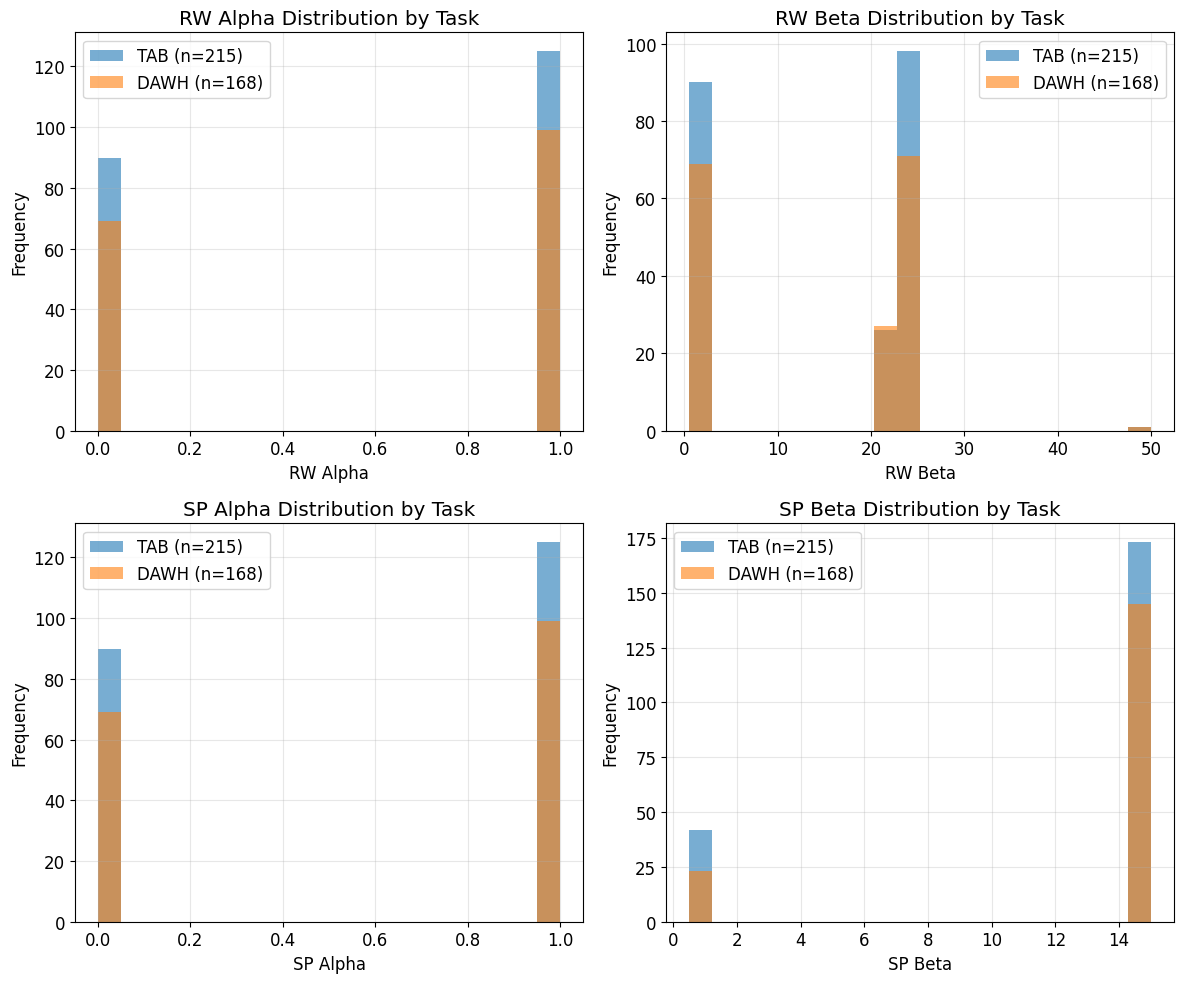


Model comparison res:

Contingency Table (AIC):
              RW wins  SP wins
TAB task:      164      51
DAWH task:     119      49

Chi-square test: chi^2 = 1.1812, p = 0.2771

Saved results to: figs/parameter_fitting_results.csv


In [ ]:
# Fit Models to Shin Data

def analyze_real_data(pkl_path="shin_data.pkl"):
    data = load_shin_data(pkl_path)
    if data is None:
        return None

    results = []

    print("\nFitting models..")

    total_sessions = sum(len(data[i]) if hasattr(data[i], '__len__') else 0
                        for i in range(len(data)))

    #this lib is great for progres bars, USE IT IN FUTURE PROJECTS
    main_pbar = tqdm(total=total_sessions, desc="Processing sessions", unit="session")

    for dataset_idx in range(len(data)):
        task_type = DATASET_TO_TASK.get(dataset_idx, "UNKNOWN")
        n_sessions = len(data[dataset_idx]) if hasattr(data[dataset_idx], '__len__') else 0

        dataset_pbar = tqdm(range(n_sessions),
                           desc=f"Dataset {dataset_idx} ({task_type})",
                           leave=False, unit="session")

        for session_idx in dataset_pbar:
            choices, rewards, task = extract_session_data(data, dataset_idx, session_idx)

            if choices is None or rewards is None:
                continue

            choices = np.array(choices)
            rewards = np.array(rewards)

            if len(choices) == 0 or len(choices) != len(rewards):
                continue

            try:

                frw = fit_RW(choices, rewards, show_progress=False)
                fsp = fit_SP(choices, rewards, show_progress=False)

                winner_AIC = "RW" if frw["AIC"] < fsp["AIC"] else "SP"
                winner_BIC = "RW" if frw["BIC"] < fsp["BIC"] else "SP"

                results.append({
                    "dataset_idx": dataset_idx,
                    "task": task,
                    "session_idx": session_idx,
                    "n_trials": len(choices),
                    "rw_alpha": frw["alpha"],
                    "rw_beta": frw["beta"],
                    "rw_ll": frw["ll"],
                    "rw_AIC": frw["AIC"],
                    "rw_BIC": frw["BIC"],
                    "sp_alpha": fsp["alpha"],
                    "sp_beta": fsp["beta"],
                    "sp_ll": fsp["ll"],
                    "sp_AIC": fsp["AIC"],
                    "sp_BIC": fsp["BIC"],
                    "winner_AIC": winner_AIC,
                    "winner_BIC": winner_BIC,
                    "AIC_diff": fsp["AIC"] - frw["AIC"],
                    "BIC_diff": fsp["BIC"] - frw["BIC"],
                    "delta_ll": fsp["ll"] - frw["ll"],
                })


                dataset_pbar.set_postfix({"fitted": len(results)})
                main_pbar.update(1)

            except Exception as e:
                dataset_pbar.write(f"Error fitting session {session_idx}: {e}")
                main_pbar.update(1)
                continue

        dataset_pbar.close()

    main_pbar.close()

    if len(results) == 0:
        return None

    df = pd.DataFrame(results)


    # Parameter summaries by task
    print("\nParameter values by task:")
    for task in ['TAB', 'DAWH']:

        task_df = df[df['task'] == task]

        if len(task_df) > 0:

            print(f"\n{task} task (n={len(task_df)} sessions):")
            print(f"RW Alpha: M={task_df['rw_alpha'].mean():.3f}, SD={task_df['rw_alpha'].std():.3f}")
            print(f"RW Beta:  M={task_df['rw_beta'].mean():.3f}, SD={task_df['rw_beta'].std():.3f}")
            print(f"SP Alpha: M={task_df['sp_alpha'].mean():.3f}, SD={task_df['sp_alpha'].std():.3f}")
            print(f"SP Beta:  M={task_df['sp_beta'].mean():.3f}, SD={task_df['sp_beta'].std():.3f}")

    # param distribution
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    ax = axes[0, 0]
    for task in ['TAB', 'DAWH']:

        task_df = df[df['task'] == task]

        if len(task_df) > 0:
            ax.hist(task_df['rw_alpha'], alpha=0.6, label=f'{task} (n={len(task_df)})', bins=20)

    ax.set_xlabel('RW Alpha')
    ax.set_ylabel('Frequency')
    ax.set_title('RW Alpha Distribution by Task')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]

    for task in ['TAB', 'DAWH']:
        task_df = df[df['task'] == task]
        if len(task_df) > 0:
            ax.hist(task_df['rw_beta'], alpha=0.6, label=f'{task} (n={len(task_df)})', bins=20)

    ax.set_xlabel('RW Beta')
    ax.set_ylabel('Frequency')
    ax.set_title('RW Beta Distribution by Task')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    for task in ['TAB', 'DAWH']:
        task_df = df[df['task'] == task]
        if len(task_df) > 0:
            ax.hist(task_df['sp_alpha'], alpha=0.6, label=f'{task} (n={len(task_df)})', bins=20)

    ax.set_xlabel('SP Alpha')
    ax.set_ylabel('Frequency')
    ax.set_title('SP Alpha Distribution by Task')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]

    for task in ['TAB', 'DAWH']:
        task_df = df[df['task'] == task]
        if len(task_df) > 0:
            ax.hist(task_df['sp_beta'], alpha=0.6, label=f'{task} (n={len(task_df)})', bins=20)
    ax.set_xlabel('SP Beta')
    ax.set_ylabel('Frequency')
    ax.set_title('SP Beta Distribution by Task')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    fname = "figs/parameter_distributions_by_task.png"
    plt.savefig(fname, dpi=220, bbox_inches="tight")
    plt.show()

    # Model comparison
    print("\nModel comparison res:")


    tab_rw = (df[df['task'] == 'TAB']['winner_AIC'] == 'RW').sum()
    tab_sp = (df[df['task'] == 'TAB']['winner_AIC'] == 'SP').sum()

    dawh_rw = (df[df['task'] == 'DAWH']['winner_AIC'] == 'RW').sum()
    dawh_sp = (df[df['task'] == 'DAWH']['winner_AIC'] == 'SP').sum()

    contingency_table = np.array([[tab_rw, tab_sp],
                                  [dawh_rw, dawh_sp]])

    print(f"\nContingency Table (AIC):")
    print(f"              RW wins  SP wins")
    print(f"TAB task:     {tab_rw:4d}    {tab_sp:4d}")
    print(f"DAWH task:    {dawh_rw:4d}    {dawh_sp:4d}")

    chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square test: chi^2 = {chi2:.4f}, p = {p_chi2:.4f}")


    output_path = "figs/parameter_fitting_results.csv"
    df.to_csv(output_path, index=False)
    print(f"\nSaved results to: {output_path}")

    return df

real_data_results = analyze_real_data()



  Dataset 0: DAWH task, 49 sessions
  Dataset 1: TAB task, 32 sessions
  Dataset 2: TAB task, 122 sessions
  Dataset 3: DAWH task, 38 sessions
  Dataset 4: DAWH task, 81 sessions
  Dataset 5: TAB task, 61 sessions


RunLength: 100%|██████████| 383/383 [00:36<00:00, 10.52it/s]


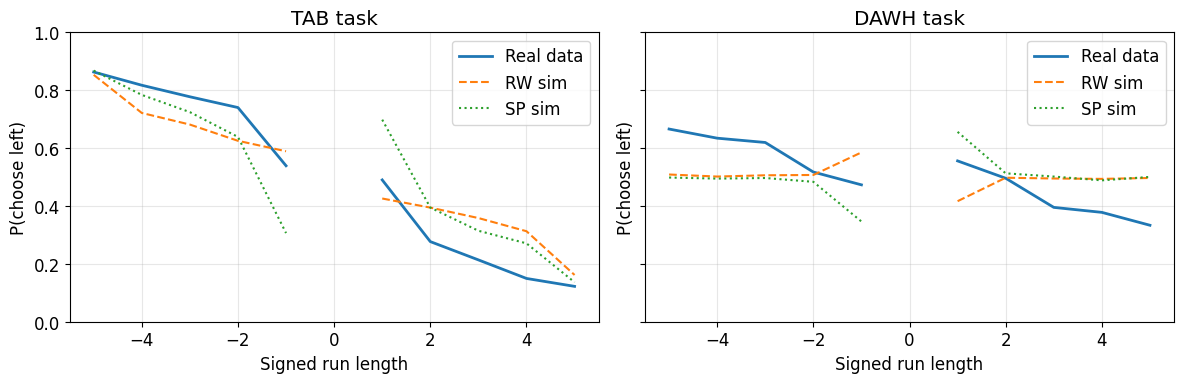

In [ ]:
# Run length analysis
# model independent diagnostics

MAX_RUN = 5
STEADY_TRIALS = 20
BLOCK_LEN_TAB = 50
BLOCK_LEN_DAWH = 50
N_SIM = 20

# realdata results
def load_results_dataframe():
    if 'real_data_results' in globals():
        return globals()['real_data_results']


    csv_path = Path('figs/parameter_fitting_results.csv')

    if csv_path.exists():
        return pd.read_csv(csv_path)

    df = analyze_real_data()
    csv_path.parent.mkdir(exist_ok=True)
    df.to_csv(csv_path, index=False)

    return df

# get the choices rewards
def get_choices_rewards(session):

    arr = np.asarray(session)

    if arr.ndim == 2 and arr.shape[1] >= 2:

        choices = arr[:, 0].astype(int)
        rewards = arr[:, 1].astype(int)

    elif arr.ndim == 2 and arr.shape[0] >= 2:
        choices = arr[0].astype(int)
        rewards = arr[1].astype(int)

    else:
        raise ValueError("Value Error")
    return choices, rewards


def compute_signed_run_predictor(choices, max_run=MAX_RUN):

    choices = np.asarray(choices, dtype=int)
    run_before = np.zeros(len(choices), dtype=int)
    prev_choice = None
    current_run = 0

    for t, choice in enumerate(choices):
        run_before[t] = np.clip(current_run, -max_run, max_run)
        if prev_choice is None or choice != prev_choice:
            current_run = 1 if choice == 1 else -1

        else:

            if choice == 1:
                current_run = current_run + 1 if current_run > 0 else 1
            else:
                current_run = current_run - 1 if current_run < 0 else -1

        prev_choice = choice

    return np.clip(run_before, -max_run, max_run)


#for steady state
def steady_state_mask(task, n_trials):\

    block_len = BLOCK_LEN_TAB if task == "TAB" else BLOCK_LEN_DAWH
    mask = np.zeros(n_trials, dtype=bool)

    for start in range(0, n_trials, block_len):
        end = min(start + block_len, n_trials)
        take_start = max(start, end - STEADY_TRIALS)
        mask[take_start:end] = True

    if not mask.any():
        mask[:] = True

    return mask


def accumulate(curve, choices, run_feat):

    for choice, run_val in zip(choices, run_feat):
        if run_val == 0:
            continue

        idx = run_val + MAX_RUN
        curve['counts'][idx] += 1

        if choice == 0:
            curve['left'][idx] += 1


# finalize the calc
def finalize(curve):

    counts = curve['counts']
    left = curve['left']

    probs = np.zeros_like(left, dtype=float)
    mask = counts > 0
    probs[mask] = left[mask] / counts[mask]
    probs[~mask] = np.nan


    return probs


# run length analysis
def analyze_run_length(real_data_results, data):

    run_values = np.arange(-MAX_RUN, MAX_RUN + 1)
    sources = {
        'real': {task: {'counts': np.zeros(len(run_values)), 'left': np.zeros(len(run_values))} for task in ['TAB', 'DAWH']},
        'rw': {task: {'counts': np.zeros(len(run_values)), 'left': np.zeros(len(run_values))} for task in ['TAB', 'DAWH']},
        'sp': {task: {'counts': np.zeros(len(run_values)), 'left': np.zeros(len(run_values))} for task in ['TAB', 'DAWH']},
    }


    for _, row in tqdm(real_data_results.iterrows(), total=len(real_data_results), desc="RunLength"):
        dataset_idx = int(row['dataset_idx'])
        session_idx = int(row['session_idx'])

        task = row['task']
        session = data[dataset_idx][session_idx]
        choices, _ = get_choices_rewards(session)

        n = len(choices)
        mask = steady_state_mask(task, n)
        run_feat = compute_signed_run_predictor(choices)
        accumulate(sources['real'][task], choices[mask], run_feat[mask])

        rw_alpha, rw_beta = row['rw_alpha'], row['rw_beta']
        sp_alpha, sp_beta = row['sp_alpha'], row['sp_beta']
        env_kwargs = {"block_len": BLOCK_LEN_TAB} if task == "TAB" else {"base": 0.02, "inc": 0.12, "max_p": 0.98}

        for _ in range(N_SIM):
            rw_choices, _ = simulate_RW(rw_alpha, rw_beta, n_trials=n, task=task, **env_kwargs)
            sp_choices, _ = simulate_SP(sp_alpha, sp_beta, n_trials=n, task=task, **env_kwargs)

            accumulate(sources['rw'][task], rw_choices[mask], compute_signed_run_predictor(rw_choices)[mask])
            accumulate(sources['sp'][task], sp_choices[mask], compute_signed_run_predictor(sp_choices)[mask])

    agg = {src: {task: finalize(sources[src][task]) for task in ['TAB', 'DAWH']} for src in sources}
    return run_values, agg

#plot the graphs
def plot_results(run_values, agg, fname='figs/run_length_analysis.png'):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    for ax, task in zip(axes, ['TAB', 'DAWH']):

        ax.plot(run_values, agg['real'][task], label='Real data', linewidth=2)
        ax.plot(run_values, agg['rw'][task], label='RW sim', linestyle='--')
        ax.plot(run_values, agg['sp'][task], label='SP sim', linestyle=':')

        ax.set_xlabel('Signed run length')
        ax.set_ylabel('P(choose left)')
        ax.set_title(f'{task} task')
        ax.set_ylim(0, 1)

        ax.legend()
        ax.grid(alpha=0.3)

    plt.tight_layout()
    Path(fname).parent.mkdir(exist_ok=True)
    plt.savefig(fname, dpi=220, bbox_inches='tight')
    plt.show()


if __name__ == '__main__':
    real_data_results = load_results_dataframe()
    data = load_shin_data('shin_data.pkl')
    run_values, agg = analyze_run_length(real_data_results, data)
    plot_results(run_values, agg)


/tmp/ipython-input-3732139730.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([tab_delta_list, dawh_delta_list], labels=['TAB', 'DAWH'])


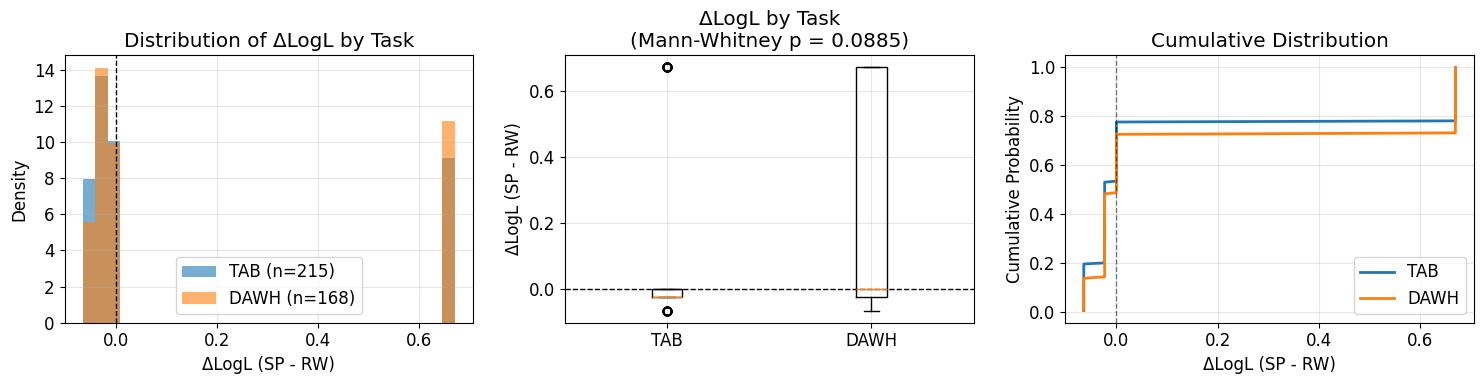

Saved: figs/delta_loglikelihood_analysis.png

Delta Log Likelihood Summary:
                   n_sessions  mean_delta_ll  median_delta_ll  std_delta_ll  \
Overall                 383.0         0.1456          -0.0232        0.3001   
TAB                     215.0         0.1292          -0.0233        0.2907   
DAWH                    168.0         0.1666          -0.0000        0.3097   
Statistical_Tests         NaN            NaN              NaN           NaN   

                   n_SP_better  pct_SP_better  n_RW_better  pct_RW_better  \
Overall                  100.0        26.1097        283.0        73.8903   
TAB                       51.0        23.7209        164.0        76.2791   
DAWH                      49.0        29.1667        119.0        70.8333   
Statistical_Tests          NaN            NaN          NaN            NaN   

                   t_test_vs_zero  p_test_vs_zero  mannwhitney_p  t_test_p  \
Overall                       NaN             NaN            NaN

In [ ]:
# Delta Log Likelihood Analysis


#Analyze delta log likelihood distributions
def analyze_delta_loglikelihood(real_data_results):

    if real_data_results is None:
        return None

    df = real_data_results.copy()

    if 'delta_ll' not in df.columns:
        if 'rw_ll' in df.columns and 'sp_ll' in df.columns:
            df['delta_ll'] = df['sp_ll'] - df['rw_ll']

        else:
            return None

    tab_delta = df[df['task'] == 'TAB']['delta_ll'].values
    dawh_delta = df[df['task'] == 'DAWH']['delta_ll'].values

    # Stats tests
    if len(tab_delta) > 0 and len(dawh_delta) > 0:
        u_stat, p_mann = mannwhitneyu(tab_delta, dawh_delta, alternative='two-sided')
        t_stat, p_ttest = ttest_ind(tab_delta, dawh_delta)

    else:
        u_stat, p_mann, t_stat, p_ttest = 0, 1, 0, 1

    t_tab, p_tab = ttest_1samp(tab_delta, 0) if len(tab_delta) > 0 else (0, 1)
    t_dawh, p_dawh = ttest_1samp(dawh_delta, 0) if len(dawh_delta) > 0 else (0, 1)

    # effect size
    if len(tab_delta) > 0 and len(dawh_delta) > 0:

        pooled_std = np.sqrt(((len(tab_delta) - 1) * np.var(tab_delta) +
                              (len(dawh_delta) - 1) * np.var(dawh_delta)) /
                             (len(tab_delta) + len(dawh_delta) - 2))

        cohens_d = (np.mean(dawh_delta) - np.mean(tab_delta)) / pooled_std if pooled_std > 0 else 0

    else:
        cohens_d = 0

    # summary statistics
    summary_stats = {
        'Overall': {
            'n_sessions': len(df),
            'mean_delta_ll': df['delta_ll'].mean(),
            'median_delta_ll': df['delta_ll'].median(),
            'std_delta_ll': df['delta_ll'].std(),
            'n_SP_better': (df['delta_ll'] > 0).sum(),
            'pct_SP_better': (df['delta_ll'] > 0).mean() * 100,
            'n_RW_better': (df['delta_ll'] < 0).sum(),
            'pct_RW_better': (df['delta_ll'] < 0).mean() * 100,
        },
        'TAB': {
            'n_sessions': len(tab_delta),
            'mean_delta_ll': np.mean(tab_delta),
            'median_delta_ll': np.median(tab_delta),
            'std_delta_ll': np.std(tab_delta),
            'n_SP_better': (tab_delta > 0).sum(),
            'pct_SP_better': (tab_delta > 0).mean() * 100,
            'n_RW_better': (tab_delta < 0).sum(),
            'pct_RW_better': (tab_delta < 0).mean() * 100,
            't_test_vs_zero': t_tab,
            'p_test_vs_zero': p_tab,
        },
        'DAWH': {
            'n_sessions': len(dawh_delta),
            'mean_delta_ll': np.mean(dawh_delta),
            'median_delta_ll': np.median(dawh_delta),
            'std_delta_ll': np.std(dawh_delta),
            'n_SP_better': (dawh_delta > 0).sum(),
            'pct_SP_better': (dawh_delta > 0).mean() * 100,
            'n_RW_better': (dawh_delta < 0).sum(),
            'pct_RW_better': (dawh_delta < 0).mean() * 100,
            't_test_vs_zero': t_dawh,
            'p_test_vs_zero': p_dawh,
        },
        'Statistical_Tests': {
            'mannwhitney_p': p_mann,
            't_test_p': p_ttest,
            'cohens_d': cohens_d,
        }
    }

    summary_df = pd.DataFrame(summary_stats).T
    summary_path = "figs/delta_ll_summary_statistics.csv"
    summary_df.to_csv(summary_path)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # histogram by task
    ax1 = axes[0]
    for task in ['TAB', 'DAWH']:

        task_df = df[df['task'] == task]

        if len(task_df) > 0:
            ax1.hist(task_df['delta_ll'], alpha=0.6, label=f'{task} (n={len(task_df)})',
                    bins=30, density=True)

    ax1.axvline(0, color='black', linestyle='--', linewidth=1)
    ax1.set_xlabel('ΔLogL (SP - RW)')
    ax1.set_ylabel('Density')
    ax1.set_title('Distribution of ΔLogL by Task')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Boxplot by task
    ax2 = axes[1]
    tab_delta_list = df[df['task'] == 'TAB']['delta_ll'].tolist()
    dawh_delta_list = df[df['task'] == 'DAWH']['delta_ll'].tolist()
    ax2.boxplot([tab_delta_list, dawh_delta_list], labels=['TAB', 'DAWH'])
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_ylabel('ΔLogL (SP - RW)')
    ax2.set_title(f'ΔLogL by Task\n(Mann-Whitney p = {p_mann:.4f})')
    ax2.grid(True, alpha=0.3)

    # Cumulative distrib graph
    ax3 = axes[2]

    for task in ['TAB', 'DAWH']:
        task_df = df[df['task'] == task]

        if len(task_df) > 0:
            sorted_delta = np.sort(task_df['delta_ll'])
            y = np.arange(1, len(sorted_delta) + 1) / len(sorted_delta)
            ax3.plot(sorted_delta, y, label=f'{task}', linewidth=2)

    ax3.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax3.set_xlabel('ΔLogL (SP - RW)')
    ax3.set_ylabel('Cumulative Probability')
    ax3.set_title('Cumulative Distribution')

    ax3.legend()

    ax3.grid(True, alpha=0.3)

    plt.tight_layout()

    fname = "figs/delta_loglikelihood_analysis.png"
    plt.savefig(fname, dpi=220, bbox_inches="tight")

    plt.show()
    print(f"Saved: {fname}")

    print("\nDelta Log Likelihood Summary:")
    print(summary_df.round(4))

    return df, summary_df

# run
if 'real_data_results' in globals() and real_data_results is not None:
    result = analyze_delta_loglikelihood(real_data_results)
    if result is not None:
        delta_ll_results, delta_ll_summary = result



Model Validation

  Dataset 0: DAWH task, 49 sessions
  Dataset 1: TAB task, 32 sessions
  Dataset 2: TAB task, 122 sessions
  Dataset 3: DAWH task, 38 sessions
  Dataset 4: DAWH task, 81 sessions
  Dataset 5: TAB task, 61 sessions


Validating models: 100%|██████████| 383/383 [00:00<00:00, 1010.15session/s]


prop_right          : r = 0.075, p = 0.1429
win_stay_rate       : r = 0.249, p = 0.0000
lose_shift_rate     : r = 0.108, p = 0.0344
reward_rate         : r = -0.069, p = 0.1761
switch_rate         : r = 0.339, p = 0.0000
mean_run_length     : r = 0.339, p = 0.0000


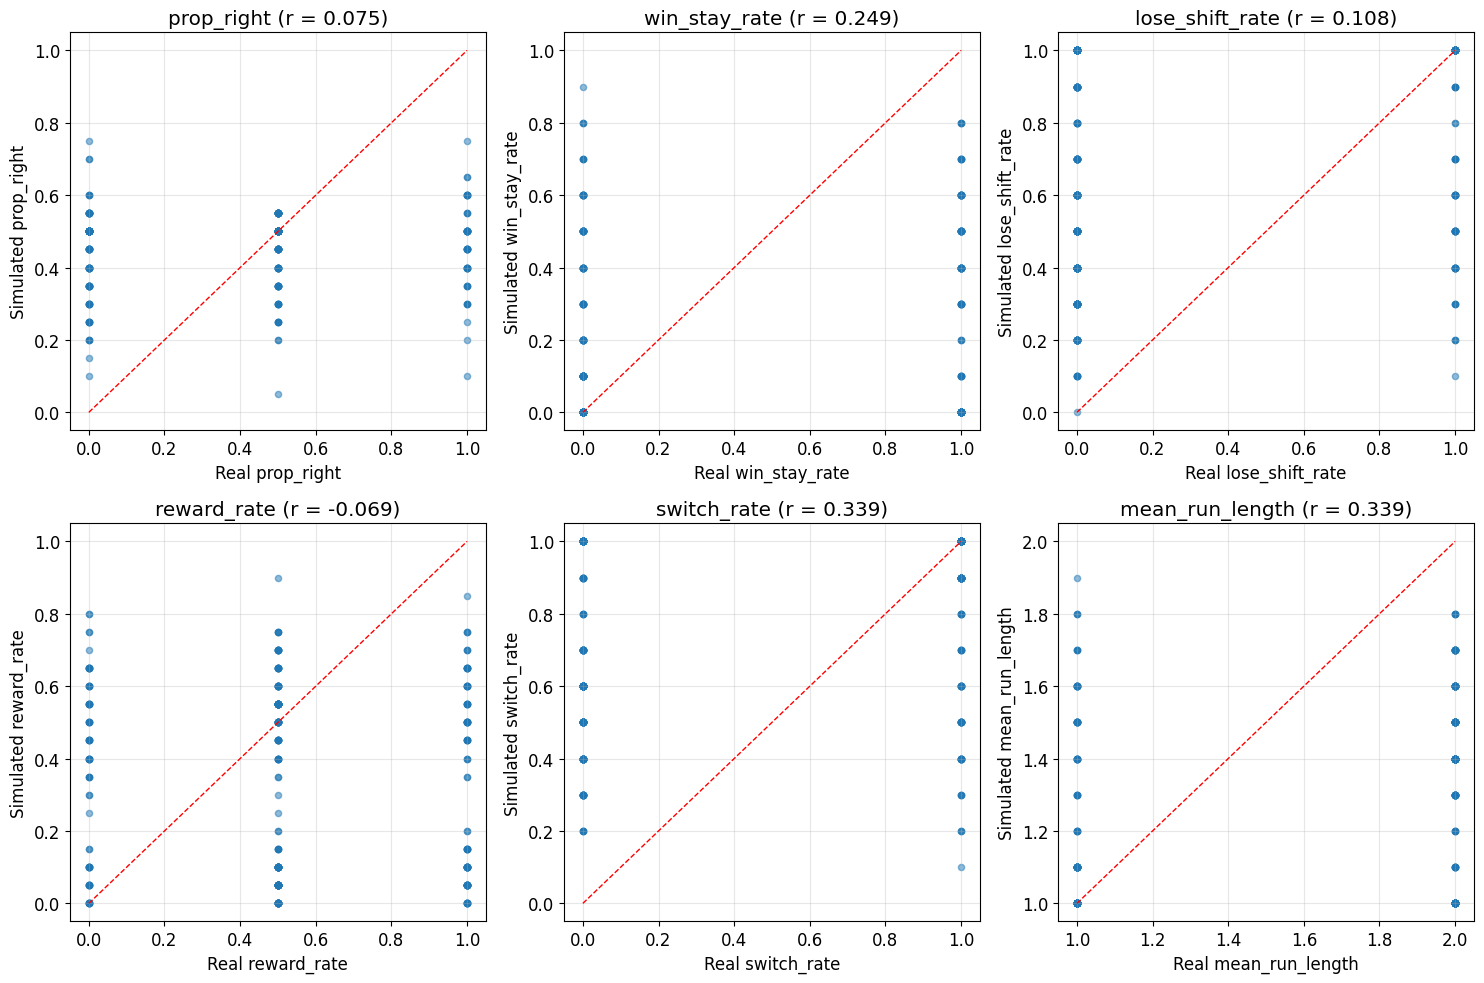


Saved: figs/model_validation.png
Saved validation results to: figs/model_validation_results.csv


In [ ]:
# Model Validation

# model independent behaviroal measures
def compute_behavioral_measures(choices, rewards):

    choices = np.array(choices)
    rewards = np.array(rewards)
    n_trials = len(choices)

    if n_trials == 0:
        return {}

    measures = {}

    measures['prop_right'] = np.mean(choices == 1)
    measures['prop_left'] = np.mean(choices == 0)

    # set zeros wsls
    if n_trials > 1:
        win_stay = 0
        win_shift = 0
        lose_stay = 0
        lose_shift = 0

        for t in range(1, n_trials):

            prev_choice = choices[t-1]
            prev_reward = rewards[t-1]
            curr_choice = choices[t]

            if prev_reward == 1:
                if curr_choice == prev_choice:
                    win_stay += 1
                else:
                    win_shift += 1
            else:
                if curr_choice == prev_choice:
                    lose_stay += 1
                else:
                    lose_shift += 1

        total_wins = win_stay + win_shift
        total_losses = lose_stay + lose_shift

        measures['win_stay_rate'] = win_stay / total_wins if total_wins > 0 else 0.0
        measures['lose_shift_rate'] = lose_shift / total_losses if total_losses > 0 else 0.0

    else:

        measures['win_stay_rate'] = 0.0
        measures['lose_shift_rate'] = 0.0

    measures['reward_rate'] = np.mean(rewards)

    if n_trials > 1:
        switches = np.sum(choices[1:] != choices[:-1])
        measures['switch_rate'] = switches / (n_trials - 1)

    else:
        measures['switch_rate'] = 0.0

    if n_trials > 0:
        run_lengths = []
        current_run = 1

        for t in range(1, n_trials):
            if choices[t] == choices[t-1]:
                current_run += 1
            else:
                run_lengths.append(current_run)
                current_run = 1

        run_lengths.append(current_run)
        measures['mean_run_length'] = np.mean(run_lengths) if len(run_lengths) > 0 else 1.0

    else:

        measures['mean_run_length'] = 1.0

    return measures


#validate models by real data comp
def model_validation(real_data_results, pkl_path="shin_data.pkl", n_simulations=10):

    if real_data_results is None:
        return None

    print("\nModel Validation\n")

    data = load_shin_data(pkl_path)

    if data is None:
        return None

    validation_results = []

    tab_env = {"block_len": 40}
    dawh_env = {"base": 0.02, "inc": 0.12, "max_p": 0.98}

    pbar = tqdm(real_data_results.iterrows(), total=len(real_data_results),
                desc="Validating models", unit="session")

    for idx, row in pbar:

        dataset_idx = int(row['dataset_idx'])
        session_idx = int(row['session_idx'])

        task = row['task']
        winner_AIC = row['winner_AIC']

        choices_real, rewards_real, _ = extract_session_data(data, dataset_idx, session_idx)


        if choices_real is None:
            continue

        choices_real = np.array(choices_real)
        rewards_real = np.array(rewards_real)

        if winner_AIC == "RW":
            alpha = row['rw_alpha']
            beta = row['rw_beta']
            model_name = "RW"

        else:
            alpha = row['sp_alpha']
            beta = row['sp_beta']
            model_name = "SP"

        env = tab_env if task == "TAB" else dawh_env
        measures_real = compute_behavioral_measures(choices_real, rewards_real)

        measures_sim_list = []

        for _ in range(n_simulations):

            if model_name == "RW":
                choices_sim, rewards_sim = simulate_RW(
                    alpha, beta, n_trials=len(choices_real), task=task, **env
                )

            else:
                choices_sim, rewards_sim = simulate_SP(
                    alpha, beta, n_trials=len(choices_real), task=task, **env
                )

            measures_sim = compute_behavioral_measures(choices_sim, rewards_sim)
            measures_sim_list.append(measures_sim)

        measures_sim_avg = {}
        for key in measures_real.keys():
            measures_sim_avg[key] = np.mean([m[key] for m in measures_sim_list])

        result = {
            'dataset_idx': dataset_idx,
            'session_idx': session_idx,
            'task': task,
            'winning_model': model_name,
            'n_trials': len(choices_real),
        }


        for key in measures_real.keys():
            result[f'real_{key}'] = measures_real[key]
            result[f'sim_{key}'] = measures_sim_avg[key]
            result[f'error_{key}'] = abs(measures_real[key] - measures_sim_avg[key])

        validation_results.append(result)

    pbar.close()

    if len(validation_results) == 0:
        print("error generating results?")
        return None

    df_val = pd.DataFrame(validation_results)


    measure_keys = ['prop_right', 'win_stay_rate', 'lose_shift_rate',
                    'reward_rate', 'switch_rate', 'mean_run_length']

    correlations = {}
    for key in measure_keys:
        real_col = f'real_{key}'
        sim_col = f'sim_{key}'
        if real_col in df_val.columns and sim_col in df_val.columns:
            r, p = pearsonr(df_val[real_col], df_val[sim_col])
            correlations[key] = {'r': r, 'p': p}
            print(f"{key:20s}: r = {r:.3f}, p = {p:.4f}")

    # comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, key in enumerate(measure_keys[:6]):

        real_col = f'real_{key}'
        sim_col = f'sim_{key}'


        if real_col in df_val.columns and sim_col in df_val.columns:
            ax = axes[i]
            ax.scatter(df_val[real_col], df_val[sim_col], alpha=0.5, s=20)

            min_val = min(df_val[real_col].min(), df_val[sim_col].min())
            max_val = max(df_val[real_col].max(), df_val[sim_col].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

            r = correlations.get(key, {}).get('r', 0)
            ax.set_xlabel(f'Real {key}')
            ax.set_ylabel(f'Simulated {key}')
            ax.set_title(f'{key} (r = {r:.3f})')
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    fname = "figs/model_validation.png"

    plt.savefig(fname, dpi=220, bbox_inches="tight")
    plt.show()

    print(f"\nSaved: {fname}")

    output_path = "figs/model_validation_results.csv"
    df_val.to_csv(output_path, index=False)

    print(f"Saved validation results to: {output_path}")

    return df_val

# run validation
if 'real_data_results' in globals() and real_data_results is not None:
    validation_results = model_validation(real_data_results)

